# Wolff Algorithm and Broad Histogram method for 3D Heisenberg Model

## Packages

In [1]:
try:
    from tqdm.notebook import tqdm as tq
except:
    !pip install tqdm
    !pip install ipywidgets
    from tqdm.notebook import tqdm as tq

import numpy as np
from scipy import integrate
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from numba import prange
import time as tm
from tqdm.notebook import tqdm as tq

from scipy.optimize import curve_fit

rcParams.update({'font.size': 11.5})

# General functions

## Initilization and neighbors

In [2]:
def gaussian(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/sigma**2)

@nb.njit
def random_initialize(L):
    """Generates a random initialization of the spins lattice.
    Args:
        L (int): Length of the lattice
    Returns:
        S (array): (L^3 x 3) array where each row represents a spin and each column contains
                    its components in x, y and z.
    """
    N = L**3
    S = np.zeros((N,3))
    PHI = np.random.uniform(0, 2*np.pi, N)
    THETA = np.random.uniform(0, np.pi, N)
    Sx = np.sin(THETA)*np.cos(PHI)
    Sy = np.sin(THETA)*np.sin(PHI)
    Sz = np.cos(THETA)
    S[:,0], S[:,1], S[:,2] = Sx, Sy, Sz 
    return S

@nb.njit
def get_neighbors(L):
    """
    Args:
        L (int): Length of the lattice
    Returns:
        nbr (array): (L^3 x 6) array where each row represents a spin and each column the
                    the index of its neighbors.
    """
    N = L**3
    nbr = np.zeros((N,6),dtype=np.int32)
    for i in range(N):
        nbr[i,:] = [(i // L) * L + (i - 1) % L, (i // L) * L + (i + 1) % L,
               (i + L) % N, (i - L) % N, (i + L**2) % N, (i - L**2) % N]
    return nbr

def central_diff(Y, X):
    n = Y.shape[0]
    dy_dx = np.zeros(n-2)
    for i in range(n-2):
        dy_dx[i] = (Y[i+2]-Y[i])/(X[i+2]-X[i])
    return dy_dx

In [3]:
@nb.njit
def Metropolis(S, nbr, T, n_flips):
    N = S.shape[0]
    for step in range(n_flips):       
        # Random vector r
        phi = np.random.uniform(0, 2*np.pi)
        z = np.random.uniform(-1,1)
        theta = np.arccos(z)
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        S_k = S[k]
        # Calculate the old and new energy (assumin the flip is accepted):
        ek_old = -np.dot(S_k, A_k)
        S_k = S_k - 2*np.dot(S_k, r)*r
        ek_new = -np.dot(S_k, A_k)
        DeltaE = ek_new - ek_old
        p = np.exp(-DeltaE/T) # Probability of accepting the move
        if np.random.random() < p:
            S[k] = S_k # Accept the move with probability p
    return S

## Thermodynamic quantities

In [4]:
def DoS(E_vals, beta):
    """
    Args:
        beta
    Returns:
        DoS (array): Density of states / DoS at E0
    """
    num_energies = E_vals.shape[0]
    entropy = np.zeros(num_energies)
    for i in range(num_energies):
        entropy[i] = integrate.trapezoid(beta[:i+1], E_vals[:i+1])
    return entropy

@nb.njit
def calculate_energy(S, nbr):
    """
    Args:
        S (array): Lattice
        nbr (array): Neighbors
    Returns:
        E (float): Energy
    """
    N = S.shape[0]
    E = 0
    for i in prange(N):
        nbrs_i = nbr[i]
        S_i = S[i]
        for ii in nbrs_i:
            E += -np.dot(S[ii], S_i)
    E = E/2
    return E

@nb.njit
def calculate_magnet(S):
    """
    Args:
        S (array): Lattice
    Returns:
        M (float): Magentization calculated as the norm of the sum of all spin vectors
    """
    S_sum = np.sum(S, axis=0)
    return np.linalg.norm(S_sum)

In [5]:
def test_calculate_energy(L):
    nbr = get_neighbors(L)
    S = random_initialize(L)
    E = calculate_energy(S, nbr)
    print('Energy1 = ', E)
    S = np.zeros((L**3,3))
    S[:,0] = 1
    E = calculate_energy(S, nbr)
    print('Energy2 =', E)

test_calculate_energy(10)

Energy1 =  -66.79549501187664
Energy2 = -3000.0


# Wolff Clusters Algorithm

In [6]:
@nb.njit
def p_acc(T, r, s_i, s_j):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    beta = 1/T
    p = 1-np.exp(min(0,-2*beta*(np.dot(r, s_i))*np.dot(r, s_j))) 
    return p

@nb.njit
def add_neighbors(neighbors, j, T, r, S, Pocket, Cluster):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    for ii in range(neighbors[j].shape[0]):
        l = int(neighbors[j][ii])
        p = p_acc(T, r, S[j,:], S[l,:])
        if (l not in Cluster) and np.random.random() < p:
            Pocket = np.append(Pocket, l)
            Cluster = np.append(Cluster, l)
    return Pocket, Cluster

@nb.njit
def generate_and_flip_cluster(S, neighbors, k, T, r):
    Pocket, Cluster = np.array([k], dtype=np.int32), np.array([k], dtype=np.int32)
    while Pocket.shape[0] != 0:
        index_j = np.random.randint(0, Pocket.shape[0])
        j = int(Pocket[index_j])
        Pocket, Cluster = add_neighbors(neighbors, j, T, r, S, Pocket, Cluster)
        Pocket = np.delete(Pocket, index_j)
    for i in Cluster:
        S[i] = S[i] - 2*np.dot(S[i], r)*r
    return S, Cluster.shape[0]

@nb.njit
def cluster_sample(S, nbr, T, c, tau):
    """
    Returns:
        S, E, M
    """
    N = S.shape[0] # Total number of spins
    # Generate cluster configuration with n_flips
    total_size = 0
    for i in range(int(c*tau)):
        while total_size<N:       
            # Random vector r
            phi = np.random.uniform(0, 2*np.pi)
            z = np.random.uniform(-1,1)
            theta = np.arccos(z)
            r = np.array([np.sin(theta)*np.cos(phi),
                          np.sin(theta)*np.sin(phi),
                          np.cos(theta)])

            # Generate and flip cluster at site k
            k = np.random.randint(0, N)
            S, size_cluster = generate_and_flip_cluster(S, nbr, k, T, r)
            total_size += size_cluster
    E = calculate_energy(S, nbr)
    M = calculate_magnet(S)
    return S, E, M

In [7]:
@nb.njit
def thermo_T(S, nbr, T, n_samples, c, tau):
    """Calculates the thermodynamic quantities at a given temperature
    Args:
        S (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
        
    Returns:
        S (array)
        M (float): Magnetization
        Cv (float): Heat capacity
        Xm (float): Magnetic Susceptibility
    """
    M, M2 = 0, 0
    E, E2 = 0, 0
    N = S.shape[0]
    for i in range(n_samples):
        S, E_current, M_current = cluster_sample(S, nbr, T, c, tau)
        E += E_current
        E2 += E_current**2
        M += M_current
        M2 += M_current**2
    M = M/n_samples
    Xm = (M2/n_samples - M**2)/T
    Cv = (E2/n_samples - (E/n_samples)**2)/(T**2)
    E = E/n_samples
    return S, (M, Xm, E, Cv)

In [8]:
n_temps = 30 # Number of temperature values 
T_vals = np.linspace(2.5, 0.5, n_temps)
Thermo_W = np.zeros((n_temps, 4))
L = 10
tau = 3
c = 3 # Safety factor
S = random_initialize(L)
nbr = get_neighbors(L)
t = tq(range(n_temps))
n_samples = 16000 # Number n of samples for calculating the thermal average
for ii in t:
    # First thermalize to desired temperautre
    S, _, _  = cluster_sample(S, nbr, T_vals[ii], c, tau)
    S, Thermo_W[ii, :] = thermo_T(S, nbr, T_vals[ii], n_samples, c, tau)
    t.set_description("T = {:.3f} : ".format(T_vals[ii]))

  0%|          | 0/30 [00:00<?, ?it/s]

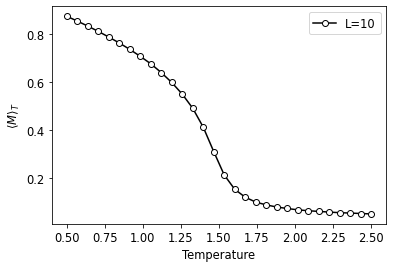

In [9]:
plt.plot(T_vals, Thermo_W[:,0]/1000,'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()
# plt.savefig('L_{}.jpg'.format(L), bbox_inches='tight')

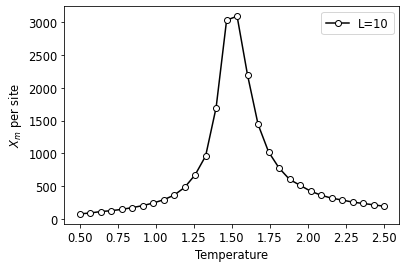

In [10]:
plt.plot(T_vals, Thermo_W[:,1],'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$X_m$ per site')
plt.legend()

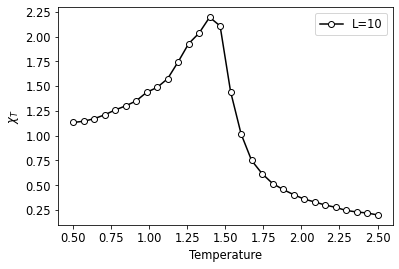

In [11]:
plt.plot(T_vals, Thermo_W[:,3]/1000,'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\chi_T$')
plt.legend()

# Broad Histogram Method

## Energize and rotate spin

In [12]:
@nb.njit
def get_angles(vector):
    """
    Args:
        vector (array)
        
    Returns:
        theta (float): Polar angle (z axis) 
        phi (float): Azimuth angle
    """
    r = np.linalg.norm(vector)
    x, y, z = vector[0], vector[1], vector[2]
    theta = np.arccos(z/r)
    if theta == 0:
        phi = 0
    else:
        phi = np.arctan2(y,x)
    return theta, phi

@nb.njit()
def energize(S, nbr, E_target, tol, max_iter):
    """
    Args:
        S (array)
        nbr (array)
        E_target (float)
        tol (float)
        max_iter (int)
    Returns:
        S (array): Energized configuration
        E_current: Energy 
    """
    N = S.shape[0]
    iteration = 0
    E_current = calculate_energy(S, nbr)
    DeltaE = abs(E_target - E_current)
    while DeltaE > tol and iteration <= max_iter:
        # Choose a spin at random
        k = np.random.randint(0, N)
        S_k = S[k]
        # Calculate the local field of that spin
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        theta, phi = get_angles(A_k)
        # Make a rotation to align A_k with the z axis
        alpha = np.pi/2 - phi
        beta = -theta
        Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0.0],
                        [np.sin(alpha), np.cos(alpha), 0.0],
                        [0.0, 0.0, 1.0]])
        Rotx = np.array([[1.0, 0.0, 0.0],
                        [0.0, np.cos(beta), np.sin(beta)],
                        [0.0, -np.sin(beta), np.cos(beta)]])
        Rot = np.dot(Rotx, Rotz)
        # Calculates the old energy
        ei_old = -np.dot(S_k, A_k)
        z = -ei_old/Anorm
        if E_current < E_target:
            z = np.random.uniform(-1, z)
        else:
            z = np.random.uniform(z, 1)
        theta = np.arccos(z)
        phi = np.random.uniform(0, 2*np.pi)
        # Get the new vector in spherical coordinates
        Sk_new = np.array([[np.sin(theta)*np.cos(phi)],
                           [np.sin(theta)*np.sin(phi)],
                           [np.cos(theta)]])
        # Rotate the new vector back to the original basis
        Sk_new = np.reshape(np.dot(Rot.T, Sk_new), A_k.shape)
        ei_new = - np.dot(Sk_new, A_k)
        S[k] = Sk_new
        DE = ei_new - ei_old
        # Calculate the new energy
        E_current += DE
        DeltaE = abs(E_target-E_current)
        iteration += 1
    return S, E_current

def test_energize(L, tol=0.01):
    print('Tolerance is ', tol)
    print('................................')
    for i in range(5):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        E_desired = np.random.uniform(-L**3, L**3)
        E_before = calculate_energy(S, nbr)
        print('E_before = ', E_before)
        S, E_after = energize(S, nbr, E_desired, tol, 200000)
        print('E_desired = ', E_desired)
        print('E_after = ', E_after)
        print('................................')
print('Testing Energize function...')
test_energize(10, 0.0005)
print('Energize tested.')

Testing Energize function...
Tolerance is  0.0005
................................
E_before =  -68.34219708860032
E_desired =  192.67697473786643
E_after =  192.67721591440844
................................
E_before =  10.96524821642736
E_desired =  537.8701317314883
E_after =  537.869714136999
................................
E_before =  64.5914441823589
E_desired =  -523.7858003279092
E_after =  -523.7856274252565
................................
E_before =  41.738934530883064
E_desired =  978.5026034141626
E_after =  978.5021356670188
................................
E_before =  -6.196383729183819
E_desired =  424.1755311090244
E_after =  424.17594414114575
................................
Energize tested.


In [13]:
@nb.njit(fastmath=True)
def rotate_spin2(S, nbr, index, E, Emin, Emax, inplace=False):
    """
    Args:
        S (arary)
        nbr (array)
        index (int)
        E (float): Current energy of the configuration
        Emin (float): Minimun energy of the window
        Emax (float): Maximum energy of the window
    Returns:
        S (array)
        ei_old (float): Energy of the spin at given index. Needed for later.
        E (float): New energy
        Anorm (float): Magnitude of the local field of the spin at given index. Needed for later
    """
    N = S.shape[0]
    DeltaEb_sup = Emax-E
    DeltaEb_inf = E-Emin
    S_i = S[index]
    nbr_i = nbr[index]
    # Local field A_i and norm
    A_i = np.sum(S[nbr_i],axis=0)
    Anorm = np.linalg.norm(A_i)
    theta, phi = get_angles(A_i)
    alpha = np.pi/2 - phi
    beta = -theta
    Rot = np.array([[np.cos(alpha), -np.sin(alpha),0.0],
                    [np.cos(beta)*np.sin(alpha), np.cos(beta)*np.cos(alpha), np.sin(beta)],
                    [-np.sin(alpha)*np.sin(beta), -np.sin(beta)*np.cos(alpha), np.cos(beta)]])
    ei_old = -np.dot(S_i, A_i)
    # Calculate the minimun and maximun values the energy of the spin i can have
    ei_min = ei_old - DeltaEb_inf
    ei_max = ei_old + DeltaEb_sup
    zmin = max(-1, -ei_max/Anorm) # These conditions ensure that z is always between [-1, 1].
    zmax = min(1, -ei_min/Anorm)
    zrand = np.random.rand()*(zmax-zmin)+zmin
    theta = np.arccos(zrand)
    phi_rand = np.random.rand()*2*np.pi
    si_new = np.array([[np.sin(theta)*np.cos(phi_rand)],
                       [np.sin(theta)*np.sin(phi_rand)],
                       [np.cos(theta)]])
    # Get si_new back to old basis
    si_new = np.dot(Rot.T, si_new).T[0]
    ei_new = -np.dot(si_new, A_i)
#     ei_new = -(si_new[0]*A_i[0]+si_new[1]*A_i[1]+si_new[2]*A_i[2])
    S[index] = si_new
    DeltaE = ei_new - ei_old
    E += DeltaE    # Update the energy
    M = calculate_magnet(S)
    return S, E, M

def test_rotate_spin2(L, Num):
    for i in range(Num):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        N = S.shape[0]
        index = np.random.randint(0,N)
        DeltaEb = 2
        E_ini = calculate_energy(S, nbr)
        Emin = E_ini - DeltaEb
        Emax = E_ini + DeltaEb
        print('Emax =', Emax)
        print('Emin =', Emin)
        print('E_initial =', E_ini)
        num_true = 0
        E = E_ini
        Timel = tm.time()
        for i in range(40000):
            S, E, _ = rotate_spin2(S, nbr, index, E, Emin, Emax, inplace=True)
            Efin = E
            num_true += Emin < Efin and Efin < Emax  
        print('Time=',tm.time()-Timel)
        print('E_final =', calculate_energy(S, nbr))
        print('Num_true out (/40000) =', num_true)
        print('.............................................')
print('Testing spin rotation function...')
test_rotate_spin2(10, 5)
print('Test completed.')

Testing spin rotation function...
Emax = 41.28680314047594
Emin = 37.28680314047594
E_initial = 39.28680314047594


/tmp/ipykernel_19/3540244521.py:45: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  ei_new = -np.dot(si_new, A_i)


Time= 1.8021152019500732
E_final = 38.75275348004588
Num_true out (/40000) = 40000
.............................................
Emax = 14.09640706092433
Emin = 10.09640706092433
E_initial = 12.09640706092433
Time= 0.293060302734375
E_final = 10.549409895683182
Num_true out (/40000) = 40000
.............................................
Emax = -5.338221458253139
Emin = -9.33822145825314
E_initial = -7.338221458253139
Time= 0.29248476028442383
E_final = -7.462700786902545
Num_true out (/40000) = 40000
.............................................
Emax = -9.20040946371214
Emin = -13.20040946371214
E_initial = -11.20040946371214
Time= 0.293515682220459
E_final = -12.77170009023497
Num_true out (/40000) = 40000
.............................................
Emax = -32.10548634738848
Emin = -36.10548634738848
E_initial = -34.10548634738848
Time= 0.291424036026001
E_final = -33.420947060080024
Num_true out (/40000) = 40000
.............................................
Test completed.


## Sampling

In [14]:
@nb.njit(fastmath=True)
def one_lattice_sweep(S, nbr, DeltaE_fix):
    N = S.shape[0]
    N_up, N_down = 0.0, 0.0
    for i in range(N):
        S_i = S[i]
        A_i = np.sum(S[nbr[i]],axis=0)
        Ai_norm = np.linalg.norm(A_i)
        ei_old = -np.dot(S_i, A_i)
        if abs(DeltaE_fix + ei_old) < Ai_norm:
            N_up += 1/N * 1/(2*Ai_norm)
        if abs(-DeltaE_fix + ei_old) < Ai_norm:
            N_down += 1/N * 1/(2*Ai_norm)
    return N_up, N_down

@nb.njit()
def one_energy(S, nbr, E_iter, DeltaEb, DeltaE_fix, num_samples = 60):
    """Calculate everything for a given energy at some T and E
    Args:
        S (array): Array of spins size (Nx3).
        nbr (array): Array containig the indices of the neighbors of each spin.
        E (float): Energy of interest.
        DeltaEb (float): Window for rotating the spins.
        DeltaE_fix (float): Fixed number for obtaining the N_up, N_down values.
        shuffle (bool): Random lattice sweep.
    Returns:
        N_up (float): Updated
        N_down (float): Updated
        Thermo (dict): Updated
    """
    N = S.shape[0]
    Thermo = np.zeros(4)
    M, M2 = 0, 0
    E, E2 = 0, 0
    N_up, N_down = 0, 0
    indices = np.arange(N)
    indices_shuffle = indices.copy()
    Emin = E_iter - DeltaEb/2 # Window centered at E_iter and size DeltaEb
    Emax = E_iter + DeltaEb/2
    E_current = calculate_energy(S, nbr)
    for k in range(40*N):
        index = np.random.randint(0,N)
        S, E_current, Mi = rotate_spin2(S, nbr, index, E_current, Emin, Emax, inplace=True)
    for i in range(num_samples):
        for k in range(4*N):
            index = np.random.randint(0,N)
            S, E_current, Mi = rotate_spin2(S, nbr, index, E_current, Emin, Emax, inplace=True)
        N_up_i, N_down_i = one_lattice_sweep(S, nbr, DeltaE_fix)
        N_up += N_up_i
        N_down += N_down_i
        M += Mi
        M2 += Mi**2
        E += E_iter
        E2 += E_iter**2 
    N_up = N_up/num_samples
    N_down = N_down/num_samples
    Thermo[0] = M/num_samples # Microcanonical average
    Thermo[1] = (M2/num_samples)-(M/num_samples)**2
    Thermo[2] = E/num_samples
    Thermo[3] = (E2/num_samples)-(E/num_samples)**2
    return N_up, N_down, Thermo

In [15]:
@nb.njit(parallel=True)
def BHM_uC(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples):
    """Samples across all energies in a given array.
    Args:
        L (int)
        E_vals (array)
        DeltaEb (float)
        DeltaE_fix (float)
        nbr (array)
    Returns:
        Nup (Array)
        Ndown (Array)
        Thermo (Array)
    """
    num_energies =  E_vals.shape[0]
    Nup = np.zeros(num_energies)
    Ndown = np.zeros(num_energies)
    range_energies = prange(num_energies)
    Thermo = np.zeros((num_energies, 4))
    for ii in range_energies:
        energy = E_vals[ii]
        S = random_initialize(L)
        # Generate a configuration whose energy falls inside the next window
        S, E_start = energize(S, nbr, energy, DeltaEb/5, 50000)
        Nup[ii], Ndown[ii], Thermo[ii] = one_energy(S, nbr, energy, DeltaEb, DeltaE_fix, num_samples)
    return Nup, Ndown, Thermo

## Analysis of results

In [16]:
L = 10
nbr = get_neighbors(L)

num_energies = 120
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
dE = E_vals[1]-E_vals[0]

DeltaEb = 2
DeltaE_fix = 1
num_samples = 2000
total_epochs = 10

Nup = np.zeros((total_epochs, num_energies))
Ndown = np.zeros((total_epochs, num_energies))
Thermo = np.zeros((total_epochs, num_energies, 4))
print('BHM_uC started.')
for i in tq(range(total_epochs)):
        Nup[i,:], Ndown[i,:], Thermo[i,:,:] = BHM_uC(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples)
print('BHM_uC finished.')
Nup_avg = np.mean(Nup, axis=0)
Ndown_avg = np.mean(Ndown, axis=0)
Thermo_avg = np.mean(Thermo, axis=0)

BHM_uC started.


  0%|          | 0/10 [00:00<?, ?it/s]

BHM_uC finished.


In [17]:
beta_uC = 1/DeltaE_fix * np.log(Nup_avg/Ndown_avg)
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
entropy = DoS(E_vals, beta_uC)

# Plotting

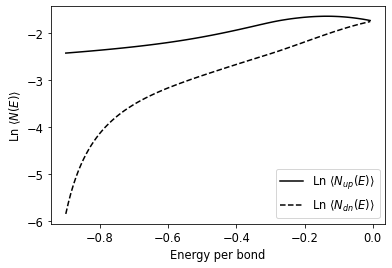

In [18]:
plt.plot(E_vals/3000, np.log(Nup_avg),'k-', label=r'Ln $\langle N_{up}(E)\rangle$')
plt.plot(E_vals/3000, np.log(Ndown_avg),'k--', label=r'Ln $\langle N_{dn}(E)\rangle$')
plt.ylabel(r'Ln $\langle N(E)\rangle$')
plt.xlabel(r'Energy per bond')
plt.legend(loc='lower right')
# plt.savefig('Log.jpg',bbox_inches='tight')

Text(0, 0.5, '$\\beta(E)$')

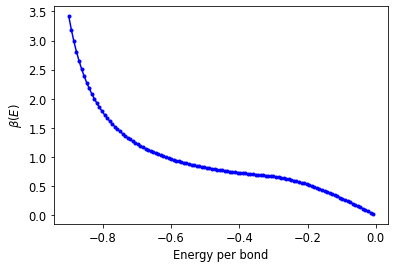

In [19]:
beta_uC = np.zeros(num_energies)
for i in range(num_energies):
    beta_uC[i] = 1/DeltaE_fix * np.log(Nup_avg[i]/Ndown_avg[i])
plt.plot(E_vals/3000, beta_uC,'b.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$\beta(E)$')
# plt.savefig('beta.jpg',dpi=400,bbox_inches='tight')

Text(0, 0.5, '$S = \\ln g(E)$')

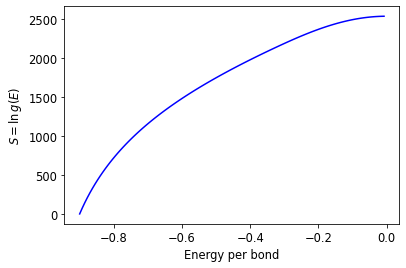

In [20]:
plt.plot(E_vals/3000, entropy,'b-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

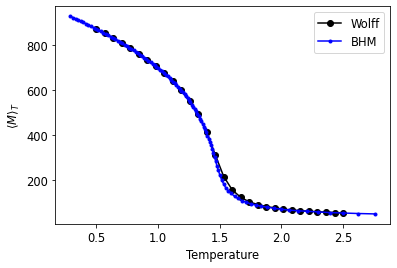

In [21]:
T_uC = 1/beta_uC
vals = (T_uC >= 0.1) & (T_uC <= 2.9)
Thermo_avg
plt.plot(T_vals, Thermo_W[:,0],'ko-',label='Wolff')
plt.plot(T_uC[vals], Thermo_avg[vals,0],'b.-',label="BHM")
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()

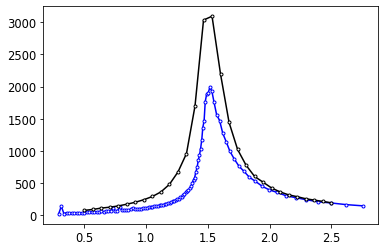

In [22]:
plt.plot(T_uC[vals], Thermo_avg[vals,1]/T_uC[vals],'b.-',mfc='w',label="BHM")
plt.plot(T_vals, Thermo_W[:,1],'k.-',mfc='w',label='L={}'.format(L))

## BHM-M: Broad Histogram Method using canonical sampling

### STEPS

1. Sample at many temperatures, usually (T, T-3s, T+3s) though other options are possible.
2. Generate (2400) samples using Wolff Clusters.
3. For each sample store in the histogram (same, not a different one) the vals of Nup, Ndown, Visits(E), Thermodynamic quantities, etc.

Let's goooo.

In [23]:
def BHM_M(L, T, n_samples, DeltaEb, DeltaE_fix):
    """Broad histogram method using Metropolis-like sampling
    Args:
        L (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
    Returns:
        M (float): Magnetization
    """
    S = random_initialize(L)
    nbr = get_neighbors(L)
    c = 3
    tau = 3
    S,_,_ = cluster_sample(S, nbr, T, c, tau)
    N_UpDown = np.zeros((n_samples, 2))
    Thermo = np.zeros((n_samples, 2))
    for i in tq(range(n_samples)):
        S, E, M = cluster_sample(S, nbr, T, c, tau)
        Thermo[i,:] = (E, M)
        Emin = E - DeltaEb/2
        Emax = E + DeltaEb/2
        N_UpDown[i,0], N_UpDown[i,1] = one_lattice_sweep(S, nbr, DeltaE_fix)
    return N_UpDown, Thermo

In [24]:
# First, define the temperatures to use Tc = 1.444
L = 10
Tc = 1.443
n_samples = 50000
DeltaEb = 2
DeltaE_fix = 1
print('BHM_M for Tc started.')
N_UpDown0, Thermo0 = BHM_M(L, Tc, n_samples, DeltaEb, DeltaE_fix)
print('BHM_M for Tc finished.')

BHM_M for Tc started.


  0%|          | 0/50000 [00:00<?, ?it/s]

BHM_M for Tc finished.


Text(0, 0.5, '$Visits$')

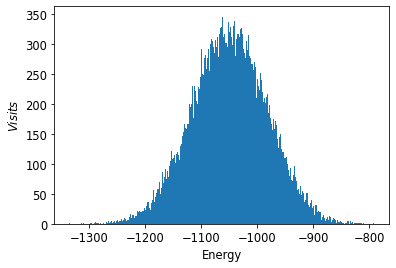

In [25]:
plt.hist(Thermo0[:,0],bins = 500)
plt.xlabel('Energy')
plt.ylabel(r'$Visits$')

In [26]:
def histogram(N_UpDown, Thermo, DeltaE):
    Emin = np.min(Thermo[:,0])
    Emax = np.max(Thermo[:,0])
    bins = int((Emax-Emin)/DeltaE)
    n_samples = Thermo.shape[0]
    BHM_array = np.zeros((bins, 8))
    Nup = N_UpDown[:,0]
    Ndown = N_UpDown[:,1]
    E_visits, E_values = np.histogram(Thermo[:,0], bins)
    belong = np.digitize(Thermo[:,0], E_values, right=True)
    E_values = E_values[:-1] + DeltaE
    BHM_array[:,0] = E_values # Energies
    BHM_array[:,1] = E_visits # Visits per energy
    num_trues_T = 0
    for i in range(n_samples):
        index = belong[i]-1
        if index==-1: index = 0
        BHM_array[index, 2] += Thermo[i,0] # Energy
        BHM_array[index, 3] += Thermo[i,0]**2 # Energy^2
        BHM_array[index, 4] += Thermo[i,1] # Magnetization
        BHM_array[index, 5] += Thermo[i,1]**2 # M^2
        BHM_array[index, 6] += Nup[i]
        BHM_array[index, 7] += Ndown[i]
    null_list = []
    for ii in range(bins):
        if BHM_array[ii,1] != 0:
            BHM_array[ii,2:] /=  BHM_array[ii,1]
        else: null_list.append(ii)
    BHM_array = np.delete(BHM_array, null_list, axis=0) # Delete empty slots
    return BHM_array

BHM_TC = histogram(N_UpDown0, Thermo0, 5)

In [27]:
Nup_Tc, Ndown_Tc = BHM_TC[:,6], BHM_TC[:,7]
E_vals_Tc = BHM_TC[:,0]
Visits_Tc = BHM_TC[:,1]
beta_M_Tc = 1/DeltaE_fix * np.log(Nup_Tc/Ndown_Tc)
T_Tc = 1/beta_M_Tc
entropy_Tc = DoS(E_vals_Tc, beta_M_Tc)

Text(0, 0.5, '$S = \\ln g(E)$')

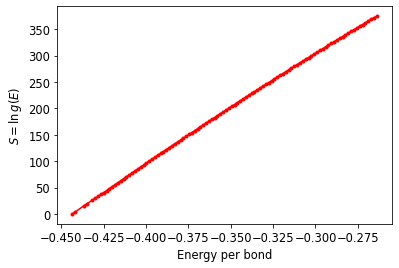

In [28]:
plt.plot(E_vals_Tc/3000, entropy_Tc,'r.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

In [29]:
# Determine Delta T =  1 sigma
popt, pcov = curve_fit(gaussian, T_Tc,  Visits_Tc)
muT = abs(popt[1])
sigmaT = abs(popt[2])
print('mu_T =', muT)
print('sigma_T =', sigmaT)

mu_T = 1.440207266141798
sigma_T = 0.04031679739090289


In [30]:
def many_temperatures(L, Tc, T_BHM, n_samples, DeltaEb, DeltaE_fix):
    N_UpDown = np.zeros((0,2))
    Thermo = np.zeros((0,2))
    for T in T_BHM:
        N_UpDown_ii, Thermo_ii = BHM_M(L, T, n_samples, DeltaEb, DeltaE_fix)
        N_UpDown = np.append(N_UpDown, N_UpDown_ii, axis=0)
        Thermo = np.append(Thermo, Thermo_ii, axis=0)
    return N_UpDown, Thermo

In [31]:
n_samples = 50000
DeltaEb = 2
DeltaE_fix = 1
print("BHM_M for many T's started.")
T_BHM = [Tc+i*sigmaT for i in [3, -3, 6, -6, -9, -12]]
N_UpDown1, Thermo1 = many_temperatures(L, Tc, T_BHM, n_samples, DeltaEb, DeltaE_fix)
print("BHM_M for many T's finished.")

BHM_M for many T's started.


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

BHM_M for many T's finished.


In [32]:
N_UpDown = np.append(N_UpDown0, N_UpDown1, axis=0)
np.savetxt("NUP_M.txt", N_UpDown)
Thermo = np.append(Thermo0, Thermo1, axis=0)
np.savetxt("THERMO_M.txt", Thermo)

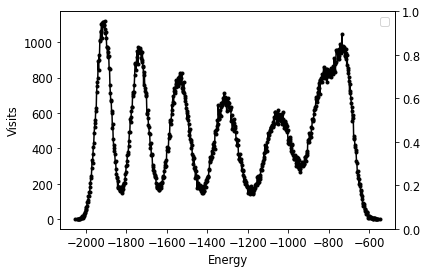

In [33]:
BHM_WOLFF = histogram(N_UpDown, Thermo, 2)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

Visits_BHM_WOLFF =  BHM_WOLFF[:,1] # Vistis
E_BHM_WOLFF = BHM_WOLFF[:,2] # Energy <E>
E2_BHM_WOLFF = BHM_WOLFF[:,3] # <E^2>
M_BHM_WOLFF = BHM_WOLFF[:,4] # Magnetization <M>
M2_BHM_WOLFF = BHM_WOLFF[:,5] # <M^2>
Nup_BHM_WOLFF = BHM_WOLFF[:,6] # N_up
Ndown_BHM_WOLFF = BHM_WOLFF[:,7] # N_down

ax1.plot(E_BHM_WOLFF, Visits_BHM_WOLFF, 'k.-',label=r'$V(E)$')
# ax2.plot(E, M2-M**2, 'b.-',label=r'$Var(M)$')
# ax2.plot(E_BHM_WOLFF, M_BHM_WOLFF, 'b.-',label=r'$M$')
ax1.set_ylabel('Visits')
# ax2.set_ylabel('Magnetization')
ax1.set_xlabel('Energy')
ax2.legend()

## Plotting

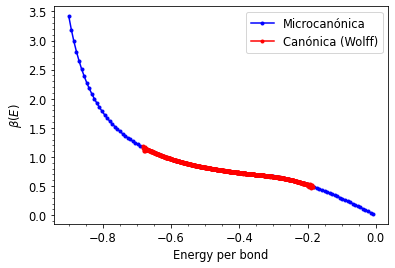

In [34]:
COND = Ndown_BHM_WOLFF>0
beta_M_BHM = 1/DeltaE_fix * np.log(Nup_BHM_WOLFF[COND]/Ndown_BHM_WOLFF[COND])
T_BHM = 1/beta_M_BHM
entropy_BHM = DoS(E_BHM_WOLFF[COND], beta_M_BHM)
plt.plot(E_vals/3000, beta_uC,'b.-',label='Microcanónica')
plt.plot(E_BHM_WOLFF[COND]/3000, beta_M_BHM,'r.-', label='Canónica (Wolff)')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$\beta(E)$')
plt.legend()
plt.minorticks_on()

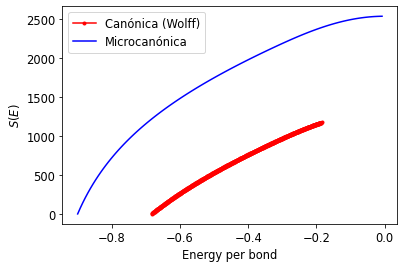

In [35]:
plt.plot(E_BHM_WOLFF[COND]/3000, entropy_BHM,'r.-',label='Canónica (Wolff)')
plt.plot(E_vals/3000, entropy,'b-',label='Microcanónica')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S(E)$')
plt.legend()

Text(0, 0.5, '$C_v$ per site')

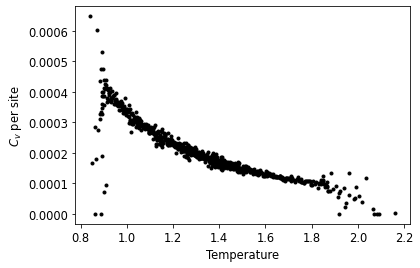

In [36]:
cv_plot =  (E2_BHM_WOLFF[COND] - (E_BHM_WOLFF[COND])**2)/(10**3*T_BHM**2)
plt.plot(T_BHM, cv_plot ,'k.')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$ per site')

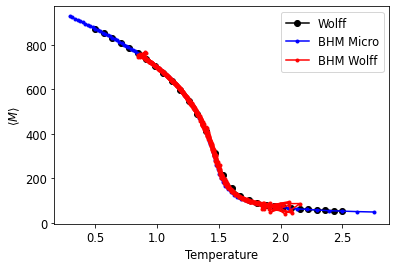

In [37]:
plt.plot(T_vals, Thermo_W[:,0],'ko-',label='Wolff')
plt.plot(T_uC[vals], Thermo_avg[vals,0],'b.-',label="BHM Micro")
plt.plot(T_BHM, M_BHM_WOLFF[COND] ,'r.-', label='BHM Wolff')
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle$')
plt.legend()

Text(0, 0.5, '$X_m$')

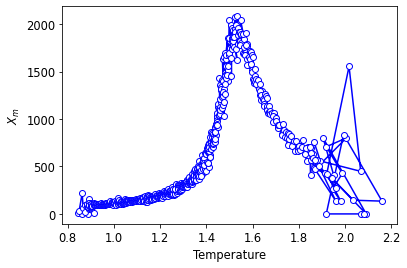

In [38]:
Xm_plot =  (M2_BHM_WOLFF[COND] - M_BHM_WOLFF[COND]**2)/T_BHM
plt.plot(T_BHM, Xm_plot ,'bo-',mfc='w')
# plt.plot(T_vals, Thermo_W[:,1],'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$X_m$')